# Tail Angle Data Parsing and Figure Creation

In [ ]:
# base and metaprogramming imports
from __future__ import annotations

import datetime
import os
import shutil
import sys
import itertools as it
import pprint as pp
from typing import Optional
import warnings
import glob
import copy
import functools as ft

# analysis imports
import h5py
import numpy as np
import pandas as pd
import pandas
import yaml
from pandas.api.types import CategoricalDtype
import scipy
import scipy.ndimage
import skimage as ski
from tifffile.tifffile import imwrite

import ants
try:
    ants.from_numpy
except Exception:
    warnings.warn(f'`ants` module import failed.')
    ants = None
else:
    print('`ants` installed and imported successfully.')

# visualization and plotting imports
import napari
import napari.settings
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# caiman imports
import bokeh.plotting as bpl
import cv2
try:
    cv2.setNumThreads(0)
except Exception:
    pass
import caiman as cm
from caiman.motion_correction import MotionCorrect
from caiman.source_extraction.cnmf import cnmf as cnmf
from caiman.source_extraction.cnmf import params as params
from caiman.utils.utils import download_demo
from caiman.utils.visualization import plot_contours, nb_view_patches, nb_plot_contour
bpl.output_notebook()

# ipynb-specific imports
try:
    import ipynbname
except Exception as e:
    warnings.warn(f'`ipynbname` module import failed with error: {e!r}')
    ipynbname = None
    
if ipynbname is not None:
    _file = ipynbname.path()
else:
    # manually set the full path to the current notebook below if `ipynbname` 
    # import fails
    raise RuntimeError('`ipynbname` import failed. Please set the `_file`'
                       'variable manually.')
    _file = ''
    
jobs_dir = os.path.split(_file)[0]
sources_dir = os.path.abspath(os.path.join(jobs_dir, '..'))
repo_dir = os.path.abspath(os.path.join(sources_dir, '..'))
config_dir = os.path.abspath(os.path.join(repo_dir, 'configs'))

# add sources directory to path
if sources_dir not in sys.path:
    sys.path.append(sources_dir)

# local imports
import c_swain_python_utils as csutils
from utilities import *
import imaging_dataset as imd
import prairie_view_imports as pvi

_basename = os.path.basename(_file)
_name = csutils.no_ext_basename(_file)

In [ ]:
[fn for fn in mpl.font_manager.findSystemFonts()
 if 'helveticaltpro' in fn.lower()]

In [83]:
# plotting defaults
mpl.font_manager.fontManager.addfont('C:\\Windows\\Fonts\\Linotype - HelveticaLTPro-Black.otf')
mpl.font_manager.fontManager.addfont('C:\\Windows\\Fonts\\Linotype - HelveticaLTPro-Bold.otf')
mpl.font_manager.fontManager.addfont('C:\\Windows\\Fonts\\Linotype - HelveticaLTPro-Roman.otf')
sns.set_style(
    'ticks',
    {'font.sans-serif': ['Helvetica LT Pro', ],
     'mathtext.fontset': ['cm',],
     'axes.linewidth': 2,
     }
)
axes_lw = 2
mpl.rcParams['axes.linewidth'] = axes_lw
mpl.rcParams['xtick.major.width'] = axes_lw
mpl.rcParams['xtick.minor.width'] = axes_lw
mpl.rcParams['ytick.major.width'] = axes_lw
mpl.rcParams['ytick.minor.width'] = axes_lw
mpl.rcParams['axes.facecolor'] = 'none'
mpl.rcParams['figure.frameon'] = False
mpl.rcParams['figure.facecolor'] = 'none'
mpl.rcParams['figure.edgecolor'] = 'none'

In [ ]:
# logging setup
log = csutils.get_logger(_name)

debug_mode = False
default_window_level = 'debug'

log_path = os.path.join(sources_dir, '..', 'logs', f'{_basename}.log')
csutils.apply_standard_logging_config(
    file_path=log_path,
    window_level='debug' if debug_mode else default_window_level,
    window_format='debug' if debug_mode else 'default')

## Load the Configs and Dataset Infos

In [ ]:
config_fname_list = [
    'cs-ii-29_config.yml',
    'cs-ii-33_config.yml',
    'cs-ii-34_config.yml',]

config_list: list[ZMIAConfig] = []
for config_fname in config_fname_list:
    config_list.append(
        ZMIAConfig(os.path.join(config_dir, config_fname))) 
    
    if config_list[-1].output_directory:
        csutils.touchdir(config_list[-1].output_directory)

all_dataset_infos = sum([c.dataset_list for c in config_list], [])

all_zz_dataset_infos = [
    di for di in all_dataset_infos                    
    if (di.type == 'zebrazoom-output' and di.run_id is not None)]

num_matched_datasets = len(all_zz_dataset_infos)
log.info('Matched {:d} zebrazoom dataset(s).', num_matched_datasets)

In [ ]:
# store some additional metadata by full path
dsi: ZMIADatasetInfo
misc_metadata_dict: dict[str, dict] = {}
for dsi in all_zz_dataset_infos:
    misc_metadata_dict[dsi.full_path] = {
        'dataset_info': dsi,
        'experiment_id': dsi.data['experiment-id'],
        'run_id': dsi.run_id
    }

## Load the Tail Angle Data

In [ ]:
HEAD_X_POS_CN = 'HeadPosX'
HEAD_Y_POS_CN = 'HeadPosY'
TAIL_X_POS_CN_FMT = 'TailPosX{:d}'
TAIL_Y_POS_CN_FMT = 'TailPosY{:d}'
TAIL_LENGTH_CN = 'TailLength'
HEADING_CN = 'Heading'
TAIL_ANGLE_CN = 'TailAngle'

HEAD_POS_KEY = 'HeadPos'
HEADING_KEY = 'Heading'
TAIL_ANGLE_KEY = 'TailAngle'
TAIL_LENGTH_KEY = 'TailLength'
TAIL_POS_X_KEY = 'TailPosX'
TAIL_POS_Y_KEY = 'TailPosY'

def h5_zz_output_to_dataframe(
        pathlike, 
        well_index=0,
        animal_index=0) -> pd.DataFrame:
    
    data_per_frame_key_fmt = (
        'dataForWell{well_index:d}'
        '/dataForAnimal{animal_index:d}'
        '/dataPerFrame')
    
    with h5py.File(pathlike, 'r') as f:
        data_key = data_per_frame_key_fmt.format(
            well_index=well_index, animal_index=animal_index)
        log.info('Reading data from key: {:s}', data_key)
        data = f[data_key]
        
        num_tail_pos = len(data[TAIL_POS_X_KEY].dtype.names)
        log.info('Found {:d} tail positions.', num_tail_pos)
        
        log.info('Creating column list')
        columns_list = [
            HEAD_X_POS_CN,
            HEAD_Y_POS_CN,
            HEADING_CN,
            TAIL_ANGLE_CN,
            TAIL_LENGTH_CN]
        x_pos_cols = [TAIL_X_POS_CN_FMT.format(i + 1) 
                      for i in range(num_tail_pos)]
        y_pos_cols = [TAIL_Y_POS_CN_FMT.format(i + 1)
                      for i in range(num_tail_pos)]
        columns_list.extend(x_pos_cols + y_pos_cols)
        
        num_frames = data[HEAD_POS_KEY][:].shape[0]
        log.info('Found {:d} frames.', num_frames)
        frame_index = pd.Index(np.arange(num_frames), name='frame-index')
        
        log.info('Initializing output dataframe...')
        zz_output_df = pd.DataFrame(
            index=frame_index,
            columns=columns_list,
            dtype=float)
        
        head_pos_data = data[HEAD_POS_KEY][:]
        head_pos_dtype = head_pos_data.dtype
        head_pos_shape = head_pos_data.shape
        zz_output_df[[HEAD_X_POS_CN, HEAD_Y_POS_CN]] = (
            head_pos_data
            .view(head_pos_dtype[0])
            .reshape(head_pos_shape + (-1, ))
            .astype(float))
           
        zz_output_df[HEADING_CN] = data[HEADING_KEY]
        zz_output_df[TAIL_ANGLE_CN] = data[TAIL_ANGLE_KEY]
        zz_output_df[TAIL_LENGTH_CN] = data[TAIL_LENGTH_KEY]
        
        tail_x_pos_data = data[TAIL_POS_X_KEY][:]
        tail_y_pos_data = data[TAIL_POS_Y_KEY][:]
        tail_pos_dtype = tail_x_pos_data.dtype
        tail_pos_shape = tail_x_pos_data.shape
        zz_output_df[x_pos_cols] = (
            tail_x_pos_data
            .view(tail_pos_dtype[0])
            .reshape(tail_pos_shape + (-1, ))
            .astype(float))
        zz_output_df[y_pos_cols] = (
            tail_y_pos_data
            .view(tail_pos_dtype[0])
            .reshape(tail_pos_shape + (-1, ))
            .astype(float))
    
    return zz_output_df

In [59]:
BOUT_NUMBER_CN = 'bout_number'
TAIL_POS_START_INDEX = 1

TAIL_X_POS_VEC_CN_FMT = 'tail_x{:02d}'
TAIL_Y_POS_VEC_CN_FMT = 'tail_y{:02d}'
TAIL_CURVATURE_VEC_CN_FMT = 'tail_c{:02d}'
TAIL_MAX_CURVATURE_CN = 'tail_max_abs_curvature'

drop_list = [
    'bout_number',
     'BoutNumber',
     'curvature1',
     'curvature2',
     'curvature3',
     'curvature4',
     'curvature5',
     'curvature6',
     'curvature7',
     'curvature8',
     'tailAngleHeatmap1',
     'tailAngleHeatmap2',
     'tailAngleHeatmap3',
     'tailAngleHeatmap4',
     'tailAngleHeatmap5',
     'tailAngleHeatmap6',
     'tailAngleHeatmap7',
     'tailAngleHeatmap8']

zz_output_df_dict: dict[str, pd.DatrFrame] = dict()
def curvature(
        xy: tuple[np.ndarray, np.ndarray], 
        axis=None) -> np.ndarray:
    x, y = xy
    dxdt = np.gradient(x, axis=axis)
    dydt = np.gradient(y, axis=axis)
    d2xdt2 = np.gradient(dxdt, axis=axis)
    d2ydt2 = np.gradient(dydt, axis=axis)
    return (
        (dxdt * d2ydt2 - dydt * d2xdt2) 
        / ((dxdt ** 2 + dydt ** 2) ** (3/2)))  

for dsi in all_zz_dataset_infos:
    log.info('Processing dataset: {:s}', dsi.full_path)
    
    if dsi.full_path.endswith('.h5'):
        zz_output_df = h5_zz_output_to_dataframe(dsi.full_path)
    else:    
        output_csv_glob = glob.glob(os.path.join(
            dsi.full_path, '*.csv'))        
        assert len(output_csv_glob) == 1, \
            f'Expected 1 output CSV file, but found {len(output_csv_glob)}'    
        output_csv_path = output_csv_glob[0]        
        zz_output_df = pd.read_csv(
            output_csv_path,
            header=0,
            skiprows=0,
            index_col=0)        
        zz_output_df.rename(
            columns={'tailAngle': TAIL_ANGLE_CN},
            inplace=True)
    
    for c in drop_list:
        try:
            zz_output_df.drop(columns=[c], inplace=True)
        except KeyError:
            pass            
    
    assert TAIL_ANGLE_CN in zz_output_df.columns, \
        f'No tail angle column found in dataframe.'
    
    log.info('Taking rolling median...')
    zz_output_df = (
        zz_output_df
        .rolling(window=3, min_periods=1, axis='index')
        .median())
    
    num_tail_positions = len([cn for cn in zz_output_df.columns
                              if cn.startswith(TAIL_X_POS_CN_FMT[:-4])])            
    log.info('Found {:d} tail positions.', num_tail_positions)
    misc_metadata_dict[dsi.full_path]['num_tail_positions'] = num_tail_positions
    
    tail_pos_indices = np.arange(num_tail_positions) + TAIL_POS_START_INDEX
    x_pos_cols = (
        [TAIL_X_POS_CN_FMT.format(i) 
           for i in tail_pos_indices])
    misc_metadata_dict[dsi.full_path]['x_pos_cols'] = x_pos_cols
    y_pos_cols = (
        [TAIL_Y_POS_CN_FMT.format(i) 
           for i in tail_pos_indices])
    misc_metadata_dict[dsi.full_path]['y_pos_cols'] = y_pos_cols
    
    curv_cols = list(
        TAIL_CURVATURE_VEC_CN_FMT.format(i) 
        for i in np.arange(num_tail_positions))
    misc_metadata_dict[dsi.full_path]['curvature_cols'] = curv_cols

    log.info('computing tail curvature...')
    x = zz_output_df[x_pos_cols].values
    y = zz_output_df[y_pos_cols].values
    zz_output_df[curv_cols] = (
        curvature((x, y), axis=1))
    
    log.info('computing max tail curvature...')    
    zz_output_df[TAIL_MAX_CURVATURE_CN] = (
        zz_output_df[curv_cols]
        .abs()
        .max(axis=1))
    log.info('Done.')
    
    zz_output_df_dict[dsi.full_path] = zz_output_df
    
zz_output_df.head()

local-nb_cs-ii-29_tail-angle-figures (  43): INFO : Processing dataset: G:\c_swain\zf_correlative_microscopy\raw_data\..\analyzed_and_generated_data\cs-ii-29_outputs\zz-output\synched_im_run_395_2024_04_04-00_25_44.h5
local-nb_cs-ii-29_tail-angle-figures (  29): INFO : Reading data from key: dataForWell0/dataForAnimal0/dataPerFrame
local-nb_cs-ii-29_tail-angle-figures (  33): INFO : Found 9 tail positions.
local-nb_cs-ii-29_tail-angle-figures (  35): INFO : Creating column list
local-nb_cs-ii-29_tail-angle-figures (  49): INFO : Found 212500 frames.
local-nb_cs-ii-29_tail-angle-figures (  52): INFO : Initializing output dataframe...
local-nb_cs-ii-29_tail-angle-figures (  71): INFO : Taking rolling median...
local-nb_cs-ii-29_tail-angle-figures (  79): INFO : Found 9 tail positions.
local-nb_cs-ii-29_tail-angle-figures (  97): INFO : computing tail curvature...
local-nb_cs-ii-29_tail-angle-figures ( 103): INFO : computing max tail curvature...
local-nb_cs-ii-29_tail-angle-figures ( 108

,HeadPosX,HeadPosY,TailPosX1,TailPosY1,TailPosX2,TailPosY2,TailPosX3,TailPosY3,TailPosX4,TailPosY4,...,tail_c00,tail_c01,tail_c02,tail_c03,tail_c04,tail_c05,tail_c06,tail_c07,tail_c08,tail_max_abs_curvature
0,208.811589,261.112028,231.597951,263.551068,254.444922,265.675556,277.339264,267.539568,300.267741,269.197182,...,-0.000250,-0.000349,-0.000395,-0.000290,-0.000186,-0.000083,0.000021,0.000068,0.000063,0.000395
1,208.807672,261.216724,231.599193,263.297198,254.415825,265.315807,277.253268,267.255135,300.107223,269.097762,...,-0.000077,-0.000123,-0.000186,-0.000218,-0.000251,-0.000283,-0.000316,-0.000254,-0.000175,0.000316
2,208.803755,261.321420,231.597951,263.551068,254.386728,265.675556,277.298796,267.412314,300.241133,269.117699,...,-0.000379,-0.000393,-0.000230,-0.000058,-0.000082,-0.000142,-0.000445,-0.000651,-0.000592,0.000651
3,208.634634,262.320437,231.486060,264.018686,254.377686,265.705626,277.292319,267.412314,300.241133,269.077556,...,0.000017,-0.000004,-0.000006,-0.000006,-0.000082,-0.000161,-0.000159,-0.000076,-0.000015,0.000161
4,208.634634,262.320437,231.486060,264.018686,254.377686,265.705626,277.298796,267.412314,300.242982,269.117699,...,0.000017,0.000015,-0.000006,-0.000069,-0.000144,-0.000138,-0.000035,0.000039,0.000048,0.000144


In [ ]:
%matplotlib qt

for full_path, zz_output_df in zz_output_df_dict.items():
    fig, axs = plt.subplots(3, 1)
    axs[0].plot(zz_output_df[TAIL_ANGLE_CN])
    axs[1].plot(zz_output_df[TAIL_MAX_CURVATURE_CN])
    axs[2].imshow(zz_output_df[curv_cols].T, aspect='auto', cmap='RdYlGn', clim=(-0.01, 0.01))
    fig.suptitle(misc_metadata_dict[full_path]['dataset_info'].name)
    # share x axes
    for ax in axs:
        ax.sharex(axs[0])
    plt.show()

In [60]:
custom_time_limits = {
    'cs-ii-34': {
        208: (0, 280000)        
    },
    'cs-ii-33': {
        195: (0, 300000)
    }
}

In [61]:
TARGET_SAMP_RATE_HZ = 500
time_start = 0
time_step = 1 / TARGET_SAMP_RATE_HZ

gaussian_filter_sigma_ms = 1e3 * (1 / 250) * 2
gaussian_filter_sigma_samp = (
    gaussian_filter_sigma_ms 
    * TARGET_SAMP_RATE_HZ 
    / 1e3)

TIME_CN = 'time'
TIME_NS_CN = 'time-nanosecond'
FRAME_INDEX_CN = 'frame-index'
FRAME_NUMBER_CN = 'frame-number'

zz_resampled_df_dict: dict[str, pd.DataFrame] = dict()
video_timecode_df_dict: dict[str, pd.DataFrame] = dict()
for full_path, zz_output_df in zz_output_df_dict.items():
    log.info('Temporally Resampling Dataset: {:s}', full_path)
    misc_metadata = misc_metadata_dict[full_path]
    run_id = misc_metadata['run_id']
    experiment_id = misc_metadata['experiment_id']
    
    log.info('Extracting video timecode...')
    video_dsi: list[ZMIADatasetInfo] = [
        dsi for dsi in all_dataset_infos
        if (dsi.type == 'behavioral-cam'
            and dsi.data['experiment-id'] == experiment_id
            and dsi.run_id == run_id)]
    
    assert len(video_dsi) == 1, \
        f'Expected 1 video dataset, but found {len(video_dsi)}'
    
    video_dsi: ZMIADatasetInfo = video_dsi[0]
    
    video_dir: str = video_dsi.full_path
    
    video_timecode_glob = glob.glob(os.path.join(
        video_dir, '*TIME.csv'))
    
    assert len(video_timecode_glob) == 1, \
        f'Expected 1 video timecode file, but found {len(video_timecode_glob)}'
    
    video_timecode_path = video_timecode_glob[0]
    
    video_timecode_df = pd.read_csv(
        video_timecode_path,
        header=0,
        skiprows=0)
    
    video_timecode_df.columns = (
        video_timecode_df.columns
        .str.strip())    
    video_timecode_df.set_index(FRAME_INDEX_CN, inplace=True)
    
    assert video_timecode_df.shape[0] == zz_output_df.shape[0], \
        f'Video timecode and zebrazoom output dataframes have different lengths.'
    
    video_timecode_df[TIME_CN] = (
        video_timecode_df[TIME_NS_CN]
        .astype(float)
        / 1e9)
    video_timecode_df[TIME_CN] = (
        video_timecode_df[TIME_CN]
        - video_timecode_df.loc[0, TIME_CN])
    
    video_timecode_df_dict[full_path] = video_timecode_df
    
    time_stop = np.floor(video_timecode_df[TIME_CN].max())
    
    try:
        time_limits = custom_time_limits[experiment_id][run_id]
    except KeyError:
        chosen_time_start = time_start
        chosen_time_stop = time_stop    
    else:
        chosen_time_start = video_timecode_df.loc[time_limits[0], TIME_CN]
        chosen_time_stop = video_timecode_df.loc[time_limits[1], TIME_CN]
    
    time_vec = np.arange(
        chosen_time_start, 
        chosen_time_stop, 
        time_step)
    time_vec = pd.Index(time_vec, name=TIME_CN)
    
    misc_metadata['time_vec'] = time_vec
    
    new_zz_df = pd.DataFrame(
        index=time_vec,
        columns=zz_output_df.columns)
    
    log.info('interpolating original df...')
    curv_cols = misc_metadata['curvature_cols']
    filled_col_list = []
    for col in zz_output_df.columns:
        if col in curv_cols + [TAIL_MAX_CURVATURE_CN, ]:
            continue
            
        filled_col_list.append(col)
        new_zz_df[col] = np.interp(
            time_vec,
            video_timecode_df[TIME_CN],
            zz_output_df[col])
        
    log.info('gaussian filtering df with sigma = {:.2f} samples ...', 
             gaussian_filter_sigma_samp)
    new_zz_df.loc[:, filled_col_list] = (
        scipy.ndimage.gaussian_filter1d(
            new_zz_df.loc[:, filled_col_list].values,
            sigma=gaussian_filter_sigma_samp,
            axis=0,
            mode='nearest'))
        
    max_angle = new_zz_df[TAIL_ANGLE_CN].abs().max()
    if max_angle < (np.pi * 1.1):
        log.info('adjusting tail angle to degrees...')
        new_zz_df[TAIL_ANGLE_CN] = np.rad2deg(new_zz_df[TAIL_ANGLE_CN])
    else:
        log.info('tail angle is already in degrees.')
        
    log.info('>>> Tail angle range is {:.2f} to {:.2f} degrees.', 
             new_zz_df[TAIL_ANGLE_CN].min(),
             new_zz_df[TAIL_ANGLE_CN].max())
    
    x_pos_cols = misc_metadata['x_pos_cols']
    y_pos_cols = misc_metadata['y_pos_cols']    
    
    log.info('computing tail curvature...')
    x = new_zz_df[x_pos_cols].values
    y = new_zz_df[y_pos_cols].values
    c = curvature((x, y), axis=1)
    new_zz_df[curv_cols] = c
    
    log.info('computing max tail curvature...')    
    new_zz_df[TAIL_MAX_CURVATURE_CN] = (
        new_zz_df[curv_cols]
        .abs()
        .max(axis=1))
    
    zz_resampled_df_dict[full_path] = new_zz_df
    log.info('Done.')

    
new_zz_df.head()

local-nb_cs-ii-29_tail-angle-figures (  19): INFO : Temporally Resampling Dataset: G:\c_swain\zf_correlative_microscopy\raw_data\..\analyzed_and_generated_data\cs-ii-29_outputs\zz-output\synched_im_run_395_2024_04_04-00_25_44.h5
local-nb_cs-ii-29_tail-angle-figures (  24): INFO : Extracting video timecode...
local-nb_cs-ii-29_tail-angle-figures (  92): INFO : interpolating original df...
local-nb_cs-ii-29_tail-angle-figures ( 105): INFO : gaussian filtering df with sigma = 4.00 samples ...
local-nb_cs-ii-29_tail-angle-figures ( 116): INFO : adjusting tail angle to degrees...
local-nb_cs-ii-29_tail-angle-figures ( 121): INFO : >>> Tail angle range is -39.92 to 106.85 degrees.
local-nb_cs-ii-29_tail-angle-figures ( 128): INFO : computing tail curvature...
local-nb_cs-ii-29_tail-angle-figures ( 134): INFO : computing max tail curvature...
local-nb_cs-ii-29_tail-angle-figures ( 141): INFO : Done.
local-nb_cs-ii-29_tail-angle-figures (  19): INFO : Temporally Resampling Dataset: G:\c_swain\

,HeadPosX,HeadPosY,TailPosX1,TailPosY1,TailPosX2,TailPosY2,TailPosX3,TailPosY3,TailPosX4,TailPosY4,...,tail_c00,tail_c01,tail_c02,tail_c03,tail_c04,tail_c05,tail_c06,tail_c07,tail_c08,tail_max_abs_curvature
time,,,,,,,,,,,,,,,,,,,,,
0.000,208.793673,261.268246,231.589319,263.547247,254.428396,265.612432,277.316587,267.460600,300.234659,269.159770,...,-0.000210,-0.000281,-0.000301,-0.000224,-0.000177,-0.000132,-0.000109,-0.000086,-0.000063,0.000301
0.002,208.786202,261.326190,231.585965,263.559660,254.424895,265.604764,277.313143,267.444940,300.230341,269.151029,...,-0.000198,-0.000262,-0.000275,-0.000205,-0.000172,-0.000141,-0.000134,-0.000116,-0.000087,0.000275
0.004,208.777576,261.391233,231.582476,263.576455,254.422195,265.599156,277.310862,267.430455,300.227473,269.142557,...,-0.000185,-0.000243,-0.000249,-0.000185,-0.000166,-0.000149,-0.000156,-0.000141,-0.000107,0.000249
0.006,208.768539,261.457849,231.579459,263.595334,254.420913,265.594970,277.310056,267.417704,300.226018,269.134904,...,-0.000172,-0.000222,-0.000223,-0.000166,-0.000160,-0.000156,-0.000172,-0.000156,-0.000118,0.000223
0.008,208.760158,261.518568,231.577631,263.612504,254.421491,265.590652,277.310629,267.406635,300.225273,269.128395,...,-0.000157,-0.000203,-0.000200,-0.000150,-0.000155,-0.000161,-0.000181,-0.000161,-0.000119,0.000203


In [62]:
%matplotlib qt

for full_path, zz_output_df in zz_resampled_df_dict.items():
    misc_metadata = misc_metadata_dict[full_path]
    num_tail_positions = misc_metadata['num_tail_positions']
    curv_cols = misc_metadata['curvature_cols']
    time_vec = misc_metadata['time_vec']
    
    fig, axs = plt.subplots(3, 1)
    axs[0].plot(zz_output_df[TAIL_ANGLE_CN])
    axs[1].plot(zz_output_df[TAIL_MAX_CURVATURE_CN])
    axs[2].imshow(zz_output_df[curv_cols].T,
                  aspect='auto',
                  cmap='Spectral',
                  clim=(-0.04, 0.04),
                  extent=(time_vec[0], time_vec[-1], 0, num_tail_positions))
    fig.suptitle(misc_metadata_dict[full_path]['dataset_info'].name)
    # share x axes
    for ax in axs:
        ax.sharex(axs[0])
    plt.show()

matplotlib.pyplot ( 414): DEBUG : Loaded backend QtAgg version 5.15.4.


In [63]:
BASELINE_CN = 'baseline_tail_angle'
MOVEMENT_FLAG_CN = 'movement_flag'
BOUT_INDEX_CN = 'bout_index'
movement_threshold_deg = 1.15

baseline_time_seconds = .030
baseline_time_samples = (
    np.round(baseline_time_seconds * TARGET_SAMP_RATE_HZ)
    .astype(int))

merge_window_seconds = .075
merge_window = (
    np.round(merge_window_seconds * TARGET_SAMP_RATE_HZ)
    .astype(int))

min_angle_range = 3.0

for full_path, zz_output_df in zz_resampled_df_dict.items():
    log.info('Computing baseline tail angle...')
    zz_output_df[BASELINE_CN] = (
        zz_output_df[TAIL_ANGLE_CN]
        .rolling(window=baseline_time_samples, 
                 center=True,
                 min_periods=1)
        .mean())
    
    log.info('Computing movement flag...')
    zz_output_df[MOVEMENT_FLAG_CN] = (
        (zz_output_df[TAIL_ANGLE_CN] 
         - zz_output_df[BASELINE_CN])
        .abs() > movement_threshold_deg)
    log.info(f'{zz_output_df[MOVEMENT_FLAG_CN].isna().sum() = }')
    
    log.info('Binary Closing (merge) movement flag with window size {:d} samples...', 
             merge_window)    
    new_values = scipy.ndimage.binary_closing(            
        zz_output_df[MOVEMENT_FLAG_CN],
        iterations=merge_window)
    zz_output_df[MOVEMENT_FLAG_CN] = pd.Series(
        new_values, index=zz_output_df.index, dtype='bool')
    
    dilation_window = 1.5 * baseline_time_samples
    dilation_window = np.round(dilation_window).astype(int)
    log.info('Binary Dilating movement flag with window size {:d} samples...', 
             dilation_window)
    new_values = scipy.ndimage.binary_dilation(            
        zz_output_df[MOVEMENT_FLAG_CN],
        iterations=dilation_window)
    zz_output_df[MOVEMENT_FLAG_CN] = pd.Series(
        new_values, index=zz_output_df.index, dtype='bool')    
    
    log.info('Computing bout index...')
    zz_output_df[BOUT_INDEX_CN] = (
        zz_output_df[MOVEMENT_FLAG_CN]
        .astype(int)
        .diff()
        .fillna(0))
    zz_output_df.loc[(zz_output_df[BOUT_INDEX_CN] < 1),  BOUT_INDEX_CN] = 0
    zz_output_df[BOUT_INDEX_CN] = (
        zz_output_df[BOUT_INDEX_CN]
        .cumsum()
        - 1)
    zz_output_df.loc[~(zz_output_df[MOVEMENT_FLAG_CN].astype(bool)), BOUT_INDEX_CN] = (
        pd.NA)
    
    bout_indices = zz_output_df[BOUT_INDEX_CN].dropna().unique()
    num_bouts = len(bout_indices)
    drop_count = 0
    min_angle_range_seen = None
    for bout_index in bout_indices:
        bout_row_mask = zz_output_df[BOUT_INDEX_CN] == bout_index
        bout_df = zz_output_df.loc[bout_row_mask, :]
        angle_range = bout_df[TAIL_ANGLE_CN].max() - bout_df[TAIL_ANGLE_CN].min()
        if min_angle_range_seen is None:
            min_angle_range_seen = angle_range
        elif angle_range < min_angle_range_seen:
            min_angle_range_seen = angle_range
        if angle_range < min_angle_range:
            zz_output_df.loc[bout_row_mask, BOUT_INDEX_CN] = pd.NA
            drop_count += 1
            
    log.info('Minimum angle range seen: {:.2f} degrees.', min_angle_range_seen)
    log.info('Dropped {:d} of {:d} bout(s) with angle range less than {:.1f} degrees.', 
             drop_count,
             num_bouts,
             min_angle_range)
    
    log.info('Done.')
    
zz_output_df.head()

local-nb_cs-ii-29_tail-angle-figures (  19): INFO : Computing baseline tail angle...
local-nb_cs-ii-29_tail-angle-figures (  27): INFO : Computing movement flag...
local-nb_cs-ii-29_tail-angle-figures (  32): INFO : zz_output_df[MOVEMENT_FLAG_CN].isna().sum() = 0
local-nb_cs-ii-29_tail-angle-figures (  34): INFO : Binary Closing (merge) movement flag with window size 38 samples...
local-nb_cs-ii-29_tail-angle-figures (  44): INFO : Binary Dilating movement flag with window size 22 samples...
local-nb_cs-ii-29_tail-angle-figures (  52): INFO : Computing bout index...
local-nb_cs-ii-29_tail-angle-figures (  82): INFO : Minimum angle range seen: 85.43 degrees.
local-nb_cs-ii-29_tail-angle-figures (  83): INFO : Dropped 0 of 4 bout(s) with angle range less than 3.0 degrees.
local-nb_cs-ii-29_tail-angle-figures (  88): INFO : Done.
local-nb_cs-ii-29_tail-angle-figures (  19): INFO : Computing baseline tail angle...
local-nb_cs-ii-29_tail-angle-figures (  27): INFO : Computing movement flag.

,HeadPosX,HeadPosY,TailPosX1,TailPosY1,TailPosX2,TailPosY2,TailPosX3,TailPosY3,TailPosX4,TailPosY4,...,tail_c03,tail_c04,tail_c05,tail_c06,tail_c07,tail_c08,tail_max_abs_curvature,baseline_tail_angle,movement_flag,bout_index
time,,,,,,,,,,,,,,,,,,,,,
0.000,208.793673,261.268246,231.589319,263.547247,254.428396,265.612432,277.316587,267.460600,300.234659,269.159770,...,-0.000224,-0.000177,-0.000132,-0.000109,-0.000086,-0.000063,0.000301,-3.538193,False,NaN
0.002,208.786202,261.326190,231.585965,263.559660,254.424895,265.604764,277.313143,267.444940,300.230341,269.151029,...,-0.000205,-0.000172,-0.000141,-0.000134,-0.000116,-0.000087,0.000275,-3.531598,False,NaN
0.004,208.777576,261.391233,231.582476,263.576455,254.422195,265.599156,277.310862,267.430455,300.227473,269.142557,...,-0.000185,-0.000166,-0.000149,-0.000156,-0.000141,-0.000107,0.000249,-3.525502,False,NaN
0.006,208.768539,261.457849,231.579459,263.595334,254.420913,265.594970,277.310056,267.417704,300.226018,269.134904,...,-0.000166,-0.000160,-0.000156,-0.000172,-0.000156,-0.000118,0.000223,-3.519983,False,NaN
0.008,208.760158,261.518568,231.577631,263.612504,254.421491,265.590652,277.310629,267.406635,300.225273,269.128395,...,-0.000150,-0.000155,-0.000161,-0.000181,-0.000161,-0.000119,0.000203,-3.515038,False,NaN


In [ ]:
%matplotlib qt
for full_path, zz_output_df in zz_resampled_df_dict.items():
    fig, axs = plt.subplots(3, 1)
    axs[0].plot(zz_output_df[TAIL_ANGLE_CN], label='Tail Angle')
    axs[0].plot(zz_output_df[BASELINE_CN], label='Baseline')
    axs[0].set(ylabel='Tail Angle (deg)',
               ylim=(-180, 180))    
    axs[0].legend()
    
    # axs[1].stem(
    #     zz_output_df.index,
    #     zz_output_df[MOVEMENT_FLAG_CN].astype(int), 
    #     markerfmt=',',
    #     linefmt='r-',
    #     label='Movement Flag')
    # axs[1].set(xlabel='Time (s)')
    # axs[1].set(ylim=(0, 10))
    # axs[1].legend()
    
    axs[2].plot(zz_output_df[BOUT_INDEX_CN], 
                label='Bout Index', lw=4, color='r')
    
    for ax in axs:
        ax.sharex(axs[0])
    plt.show()

In [64]:
def tail_angle_bout_overview_subfig():
    for full_path, zz_output_df in zz_resampled_df_dict.items():
        misc_metadata = misc_metadata_dict[full_path]
        dsi = misc_metadata['dataset_info']
        experiment_id = misc_metadata['experiment_id']
        run_id = misc_metadata['run_id']
        fish_id = dsi.data['fish-id']
        time_vec = misc_metadata['time_vec']
        
        sec_factor = 120
        
        max_minute = np.ceil(time_vec.max() / sec_factor) * sec_factor / 60
        
        fig = plt.figure(figsize=(8, 2))
        ax = fig.add_subplot(1, 1, 1)
        ax.plot(
            zz_output_df[TAIL_ANGLE_CN],
            'k',
            lw=2.5)
        upper = (zz_output_df[MOVEMENT_FLAG_CN].astype(float) * 360) - 180
        lower = np.zeros_like(upper) - 180
        ax.fill_between(
            zz_output_df.index, 
            lower, 
            upper, 
            color=sns.color_palette('muted')[3],
            alpha=0.3,
            zorder=0, 
            linewidth=2)
        ax.axhline(0, color='k', lw=1, ls=':', zorder=0) 
        xticks = np.arange(0, 1 + (max_minute * 60), 120)
        ax.set(xlabel='Time (m:s)',
               ylabel='Tail Angle ($\mathdefault{\degree}$)',
               xticks=xticks,
               xticklabels=[f'{int(t // 60):d}:{int(t % 60):02d}' 
                            for t in xticks],
               yticks=[-90, 0, 90],
               xlim=(-20, xticks[-1]),
               ylim=(-150, 150))
        ax.text(
            s=f'{experiment_id}{fish_id}, run {run_id}',
            x=0.99, y=0.99, 
            ha='right', va='top', 
            transform=ax.transAxes)
        bout_indices = zz_output_df[BOUT_INDEX_CN].dropna().unique()
        last_label_time = None
        for bout_index in bout_indices:
            bout_mask = zz_output_df[BOUT_INDEX_CN] == bout_index
            bout_df = zz_output_df.loc[bout_mask, :]
            bout_end = (
                bout_df
                .index
                .max())
            bout_timestamp = (bout_df.index[0] + bout_df.index[-1]) / 2
            
            if last_label_time is None:
                pass
            elif (bout_timestamp - last_label_time) > (max_minute * 3):
                pass
            else:                
                continue
                
            last_label_time = bout_timestamp            
            ax.text(
                s=f'{int(bout_index) + 1:d}',
                x=bout_end+3, y=-147, 
                ha='left', va='bottom', 
                color=sns.color_palette('muted')[3])
        fig.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.25)
        sns.despine(ax=ax, right=True, top=True, trim=True)
        
        fig_name = f'{experiment_id}{fish_id}_run{run_id}_tail_angle_bout_overview'   
        yield fig_name, fig

fig_generator = tail_angle_bout_overview_subfig()

matplotlib.pyplot ( 414): DEBUG : Loaded backend module://matplotlib_inline.backend_inline version unknown.


('cs-ii-29B_run395_tail_angle_bout_overview',
 <Figure size 800x200 with 1 Axes>)

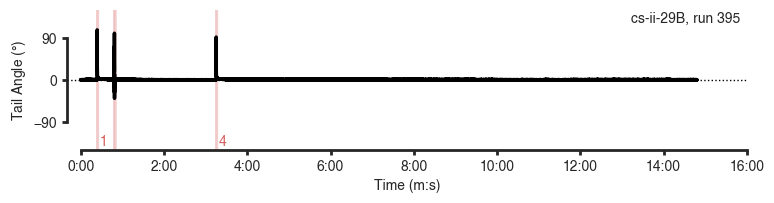

In [65]:
%matplotlib inline
next(fig_generator)

In [95]:
def bout_zoom_subfig():    
    for full_path, zz_output_df in zz_resampled_df_dict.items():
        misc_metadata = misc_metadata_dict[full_path]
        dsi = misc_metadata['dataset_info']
        experiment_id = misc_metadata['experiment_id']
        run_id = misc_metadata['run_id']
        fish_id = dsi.data['fish-id']      
        
        bout_indices = zz_output_df[BOUT_INDEX_CN].dropna().unique()
        
        for bout_index in bout_indices:    
            fig = plt.figure(figsize=(4.5, 4))
            ax1 = fig.add_subplot(2, 1, 1)
            
            bout_df = zz_output_df.loc[
                zz_output_df[BOUT_INDEX_CN] == bout_index, :]
            
            ylim_raw = np.array([
                bout_df[TAIL_ANGLE_CN].min(),
                bout_df[TAIL_ANGLE_CN].max()])
            y_range = np.diff(ylim_raw)
            ylim = ylim_raw + (np.array([-1, 1]) * y_range * 0.15)
            if y_range < 5:
                ybar = 1
            elif y_range < 10:
                ybar = 2
            elif y_range < 45:
                ybar = 5
            elif y_range < 90:
                ybar = 10
            elif y_range < 180:
                ybar = 30
            else:
                ybar = 45
            
            start_min = int(bout_df.index[0] // 60)
            start_sec = float(bout_df.index[0] % 60)
            
            time_series = bout_df.index - bout_df.index[0]
            bout_duration = time_series[-1]
            
            video_timecode_df = video_timecode_df_dict[full_path]
            frame_index = (
                (video_timecode_df[TIME_CN] - bout_df.index[0])
                .abs()
                .idxmin())
            
            ax1.plot(
                time_series,
                bout_df[TAIL_ANGLE_CN],
                'k',
                lw=2.5)
            # ax1.axhline(0, color='k', lw=1, ls=':', zorder=0, alpha=0.5)
            ax1.set_ylabel(f'$\mathdefault{{{ybar:d}\degree}}$',
                           loc='bottom')
            ax1.set(
                yticks=[ylim[0], ylim[0] + ybar],
                yticklabels=[],
                xticks=[],
                ylim=ylim,
                xlim=(-1 * (bout_duration * 0.03), time_series[-1]))
            ax1.text(
                s=f'{experiment_id}{fish_id}, '
                  f'run {run_id}, '
                  f'bout {int(bout_index) + 1:d}, '
                  f'frame index {frame_index}',
                x=0.99, y=0.99, 
                ha='right', va='top', 
                transform=ax1.transAxes)
            ax1.axhline(0, color='k', lw=1, ls=':', zorder=0, alpha=0.5)
            sns.despine(ax=ax1, right=True, top=True, bottom=True, trim=True)
            
            ax2 = fig.add_subplot(2, 1, 2)
            im = ax2.imshow(
                bout_df[curv_cols].T, 
                aspect='auto', 
                cmap='RdYlGn',
                interpolation='spline36',
                clim=(-0.03, 0.03),
                extent=(time_series[0], 
                        time_series[-1], 
                        0, 
                        num_tail_positions))
            ax2.set_xlabel(
                f'50 ms', 
                loc='left')
            ax2.set(
                yticks=[],
                xticks=[0, 0.05],
                xticklabels=[],
                xlim=(-1 * (bout_duration * 0.03), time_series[-1]))
            sns.despine(ax=ax2, right=True, top=True, left=True, trim=True)   
            fig.subplots_adjust(left=0.14, 
                                right=0.98, 
                                top=0.98, 
                                bottom=0.12,
                                hspace=0.02)
            cax = fig.add_axes([0.67, 0.07, 0.27, 0.03])
            cb = fig.colorbar(
                im, 
                cax=cax, 
                orientation='horizontal', 
                ticks=[-0.02, 0, 0.02],
                drawedges=False)        
            cb.outline.set_visible(False)
            sns.despine(ax=cax, 
                        left=True, right=True, top=True, bottom=True)
            
            fig_name = os.path.join(
                'individual_bouts',
                f'{experiment_id}{fish_id}_run-{run_id:03d}'
                f'_bout-{int(bout_index) + 1:03d}_tail_angle_zoom')
            
            yield fig_name, fig

zoom_subfig_generator = bout_zoom_subfig()

matplotlib.pyplot ( 414): DEBUG : Loaded backend module://matplotlib_inline.backend_inline version unknown.
matplotlib.colorbar ( 859): DEBUG : locator: <matplotlib.ticker.FixedLocator object at 0x0000028BE3A2A9B0>


('individual_bouts\\cs-ii-29B_run-395_bout-001_tail_angle_zoom',
 <Figure size 450x400 with 3 Axes>)

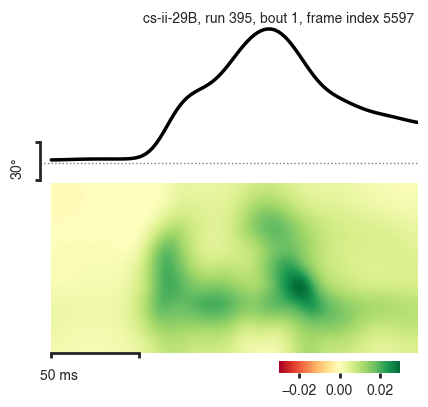

In [96]:
%matplotlib inline
next(zoom_subfig_generator)

## Create Bout List

In [68]:
bout_list = []

for full_path, zz_output_df in zz_resampled_df_dict.items():
    misc_metadata = misc_metadata_dict[full_path]
    dsi = misc_metadata['dataset_info']
    experiment_id = misc_metadata['experiment_id']
    run_id = misc_metadata['run_id']
    fish_id = dsi.data['fish-id']
    video_timecode_df = video_timecode_df_dict[full_path]
    
    zz_ouput_df = zz_output_df.copy()
    bout_indices = zz_output_df[BOUT_INDEX_CN].dropna().unique()        
    
    for bout_index in bout_indices:    
        bout_df = zz_output_df.loc[
            zz_output_df[BOUT_INDEX_CN] == bout_index, :]
        
        bout_duration = bout_df.index[-1] - bout_df.index[0]
        bout_timestamp = bout_df.index[0] + (bout_duration / 2)
        bout_framestamp = (
            video_timecode_df[TIME_CN]
            .sub(bout_timestamp)
            .abs()
            .idxmin())
        
        bout_list.append({
            'experiment_id': experiment_id,
            'run_id': run_id,
            'fish_id': experiment_id + fish_id,
            'bout_index': int(bout_index),
            'bout_timestamp': bout_timestamp,
            'bout_framestamp': bout_framestamp,
            'bout_duration': bout_duration,
            'bout_max_curvature': bout_df[TAIL_MAX_CURVATURE_CN].max(),
            'bout_max_angle_range': (bout_df[TAIL_ANGLE_CN].max() 
                                     - bout_df[TAIL_ANGLE_CN].min())})
        
bout_prop_df = pd.DataFrame(bout_list)

bout_prop_df.head()


,experiment_id,run_id,fish_id,bout_index,bout_timestamp,bout_framestamp,bout_duration,bout_max_curvature,bout_max_angle_range
0,cs-ii-29,395,cs-ii-29B,0,23.637,5623,0.210,0.029499,104.740924
1,cs-ii-29,395,cs-ii-29B,1,48.073,11463,0.250,0.097845,85.426512
2,cs-ii-29,395,cs-ii-29B,2,48.502,11566,0.288,0.197285,139.522245
3,cs-ii-29,395,cs-ii-29B,3,195.123,46548,0.198,0.035623,86.689587
4,cs-ii-29,396,cs-ii-29B,0,48.291,12067,0.370,0.029650,70.336598


In [69]:
bout_prop_df['bout_duration_ms'] = bout_prop_df.bout_duration.mul(1e3)
bout_prop_df['unique_run_id'] = (
        bout_prop_df.experiment_id 
        + '_' 
        + bout_prop_df.run_id.astype(str))
bout_prop_df['count_col'] = 1

In [70]:
bout_prop_df

,experiment_id,run_id,fish_id,bout_index,bout_timestamp,bout_framestamp,bout_duration,bout_max_curvature,bout_max_angle_range,bout_duration_ms,unique_run_id,count_col
0,cs-ii-29,395,cs-ii-29B,0,23.637,5623,0.210,0.029499,104.740924,210.0,cs-ii-29_395,1
1,cs-ii-29,395,cs-ii-29B,1,48.073,11463,0.250,0.097845,85.426512,250.0,cs-ii-29_395,1
2,cs-ii-29,395,cs-ii-29B,2,48.502,11566,0.288,0.197285,139.522245,288.0,cs-ii-29_395,1
3,cs-ii-29,395,cs-ii-29B,3,195.123,46548,0.198,0.035623,86.689587,198.0,cs-ii-29_395,1
4,cs-ii-29,396,cs-ii-29B,0,48.291,12067,0.370,0.029650,70.336598,370.0,cs-ii-29_396,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2709,cs-ii-34,209,cs-ii-34A,247,1085.954,265551,0.804,0.019699,93.562802,804.0,cs-ii-34_209,1
2710,cs-ii-34,209,cs-ii-34A,248,1087.414,265909,1.504,0.865668,91.282776,1504.0,cs-ii-34_209,1
2711,cs-ii-34,209,cs-ii-34A,249,1088.927,266282,0.870,0.674952,43.915599,870.0,cs-ii-34_209,1
2712,cs-ii-34,209,cs-ii-34A,250,1125.573,275233,0.322,0.023337,105.100079,322.0,cs-ii-34_209,1


In [75]:
df_stack = []
for full_path, zz_output_df in zz_resampled_df_dict.items():
    misc_metadata = misc_metadata_dict[full_path]
    dsi = misc_metadata['dataset_info']
    experiment_id = misc_metadata['experiment_id']
    run_id = misc_metadata['run_id']
    fish_id = dsi.data['fish-id']
    
    zz_output_df['experiment_id'] = experiment_id
    zz_output_df['run_id'] = run_id
    zz_output_df['fish_id'] = experiment_id + fish_id
    zz_output_df['unique_run_id'] = experiment_id + '_' + f'{run_id:d}'
    
    df_stack.append(zz_output_df)
    
multirun_tail_angle_df = pd.concat(df_stack)
multirun_tail_angle_df.reset_index(inplace=True)

In [77]:
multirun_tail_angle_df.head()

,time,HeadPosX,HeadPosY,Heading,TailAngle,TailLength,TailPosX1,TailPosX2,TailPosX3,TailPosX4,...,tail_c07,tail_c08,tail_max_abs_curvature,baseline_tail_angle,movement_flag,bout_index,experiment_id,run_id,fish_id,unique_run_id
0,0.000,211.005567,266.519228,3.164222,-0.652486,186.053070,231.490431,252.015929,272.622453,293.292741,...,0.000325,0.000273,0.002225,-0.338951,False,NaN,cs-ii-29,395,cs-ii-29B,cs-ii-29_395
1,0.002,211.004454,266.536520,3.164130,-0.579131,186.308302,231.531654,252.101342,272.744496,293.445230,...,0.000436,0.000350,0.001988,-0.295292,False,NaN,cs-ii-29,395,cs-ii-29B,cs-ii-29_395
2,0.004,211.003358,266.554801,3.164033,-0.492650,186.575942,231.575559,252.192100,272.873966,293.606739,...,0.000571,0.000447,0.001729,-0.255962,False,NaN,cs-ii-29,395,cs-ii-29B,cs-ii-29_395
3,0.006,211.002347,266.573480,3.163934,-0.395919,186.841561,231.619893,252.283405,273.003976,293.768658,...,0.000728,0.000564,0.001458,-0.221958,False,NaN,cs-ii-29,395,cs-ii-29B,cs-ii-29_395
4,0.008,211.001484,266.591917,3.163836,-0.293480,187.093191,231.662576,252.370785,273.128168,293.923126,...,0.000899,0.000695,0.001196,-0.193998,False,NaN,cs-ii-29,395,cs-ii-29B,cs-ii-29_395


In [78]:
output_directory = (
    r'G:\c_swain\zf_correlative_microscopy'
    r'\analyzed_and_generated_data'
    r'\cs-ii-[29,33,34]_outputs')
csutils.touchdir(output_directory)

save_path = os.path.join(
    output_directory, 
    'cs-ii-[29,33,34]_tail-movement-timecourses.pd')
log.info('Saving bout timecourses dataframe to {:s}', save_path)
csutils.save_to_disk(multirun_tail_angle_df, save_path)

save_path = os.path.join(
    output_directory, 
    'cs-ii-[29,33,34]_swim-bout-statistics.pd')
log.info('Saving bout timecourses dataframe to {:s}', save_path)
csutils.save_to_disk(bout_prop_df, save_path)

local-nb_cs-ii-29_tail-angle-figures (  10): INFO : Saving bout timecourses dataframe to G:\c_swain\zf_correlative_microscopy\analyzed_and_generated_data\cs-ii-[29,33,34]_outputs\cs-ii-[29,33,34]_tail-movement-timecourses.pd
local-nb_cs-ii-29_tail-angle-figures (  16): INFO : Saving bout timecourses dataframe to G:\c_swain\zf_correlative_microscopy\analyzed_and_generated_data\cs-ii-[29,33,34]_outputs\cs-ii-[29,33,34]_swim-bout-statistics.pd


In [80]:
# count number of bouts in each run within windows of size `sample_period_sec`
sample_period_sec = 60

max_time = bout_prop_df.bout_timestamp.max()
num_windows = (
    np.ceil(max_time / sample_period_sec)
    .astype(int)
    .item() 
    + 1)
bins = (
    np.arange(
        0, 
        num_windows * sample_period_sec, 
        sample_period_sec)
    .astype(int)
    .tolist())
bout_prop_df['bout_time_bin'] = pd.cut(
    bout_prop_df.bout_timestamp, bins=bins)
bout_freq_df = (
    bout_prop_df
    .pivot_table(
        index=['fish_id', 'experiment_id', 'unique_run_id'],
        columns='bout_time_bin',
        values='count_col',
        aggfunc='count')
    .replace(0, np.nan)
    .div(sample_period_sec)
    .melt(
        ignore_index=False,
        value_name='bout_frequency')
    .dropna()
    .reset_index())

bout_freq_df.head()

,fish_id,experiment_id,unique_run_id,bout_time_bin,bout_frequency
0,cs-ii-29B,cs-ii-29,cs-ii-29_395,"(0, 60]",0.050000
1,cs-ii-29B,cs-ii-29,cs-ii-29_396,"(0, 60]",0.016667
2,cs-ii-29B,cs-ii-29,cs-ii-29_399,"(0, 60]",0.016667
3,cs-ii-33A,cs-ii-33,cs-ii-33_188,"(0, 60]",0.033333
4,cs-ii-33A,cs-ii-33,cs-ii-33_189,"(0, 60]",0.133333


In [88]:
%matplotlib inline
catplot_kwargs = dict(
    hue='fish_id',
    palette='muted',
    height=4,
    aspect=1,
    
    # kind='boxen',
    # gap=0.15,
    # fill=False,
    # linewidth=4,
    # width_method='exponential',
    # k_depth='trustworthy',
    
    kind='violin',
    cut=0,
    gap=0.15,
    bw_adjust=0.9,
    density_norm='width',
)

def bout_frequency_boxplot():
    facet_grid = sns.catplot(
        data=bout_freq_df, 
        x='bout_frequency', 
        **catplot_kwargs,
        log_scale=True,
        # alpha=0.8,
        # line_kws=dict(
        #     alpha=0.8,
        # ),
        # showfliers=False
    )        
    
    sns.swarmplot(
        data=bout_freq_df, 
        x='bout_frequency', 
        dodge=True,
        hue='fish_id',
        palette='muted',
        linewidth=0.5,
        edgecolor='k',
        size=4,
        legend=False,
    )
    
    (facet_grid
     .set(xlabel='Bout Frequency',
          xticks=[1/60, 10/60, 1],
          xticklabels=['1/min', '10/min', '1/s'],
          ylim=(0.4, -0.4),
          yticks=[])
     .despine(left=True, trim=True)
     )    
    yield 'MULTIRUN_bout_frequency_boxplot', facet_grid.figure

def bout_duration_boxplot():
    facet_grid = sns.catplot(
        data=bout_prop_df, 
        x='bout_duration', 
        **catplot_kwargs,
        log_scale=True,
    )
    
    (facet_grid
     .set(xlabel='Bout Duration',
          xticks=[0.1, 0.3, 1, 3],
          xticklabels=['100 ms', '300 ms', '1 s', '3 s'],
          ylim=(0.4, -0.4),
          yticks=[])
     .despine(left=True)
     )
    yield 'MULTIRUN_bout_duration_boxplot', facet_grid.figure

def bout_angle_rage_boxplot():
    facet_grid = sns.catplot(
        data=bout_prop_df, 
        x='bout_max_angle_range', 
        **catplot_kwargs,
    )
    
    filt_freq_df = bout_prop_df.query('bout_max_angle_range > 25')
    vp = sns.violinplot(
        data=filt_freq_df, 
        x='bout_max_angle_range', 
        hue='fish_id',
        palette='muted',
        alpha=0.3,
        cut=catplot_kwargs['cut'],
        gap=catplot_kwargs['gap'],    
        bw_adjust=catplot_kwargs['bw_adjust'],
        density_norm=catplot_kwargs['density_norm'],
        inner=None,
        legend=False,
        zorder=0,
    )
    
    (facet_grid
     .set(xlabel='Bout Tail Angle Range ($\mathdefault{\degree}$)',
          xticks=[0, 90, 180, 270],
          ylim=(0.4, -0.4),
          yticks=[])
     .despine(left=True, trim=True)
     )
    yield 'MULTIRUN_bout_angle_range_boxplot', facet_grid.figure

bout_frequency_boxplot()
bout_duration_boxplot()
bout_angle_rage_boxplot()

matplotlib.pyplot ( 414): DEBUG : Loaded backend module://matplotlib_inline.backend_inline version unknown.


<generator object bout_angle_rage_boxplot at 0x0000028B9D5337D0>

## Save the Figures

In [98]:
fig_dir = os.path.join(
    config_list[0].output_directory, 
    '..',
    'multi_experiment_figures',
    'tail_angle_figures')
png_dir = os.path.join(fig_dir, 'png')
pdf_dir = os.path.join(fig_dir, 'pdf')
csutils.touchdir(fig_dir)
csutils.touchdir(png_dir)
csutils.touchdir(pdf_dir)

overwrite = True # <<<<<<<<<<<<< False | change to prevent overwriting

all_figures = it.chain(
    tail_angle_bout_overview_subfig(),
    bout_frequency_boxplot(),
    bout_duration_boxplot(),
    bout_angle_rage_boxplot(),
    bout_zoom_subfig(),
    )

for fig_name, fig in all_figures:
    for ext in ('png', 'pdf'):
        fig_path = os.path.join(
            fig_dir, 
            f'{ext.upper()}s', 
            f'{fig_name}.{ext}')
        csutils.touchdir(os.path.dirname(fig_path))
        if not os.path.exists(fig_path) or overwrite:
            fig.savefig(fig_path, dpi=300)
    plt.close(fig)

matplotlib.backends.backend_pdf ( 918): DEBUG : Assigning font /F1 = 'C:\\Windows\\Fonts\\Linotype - HelveticaLTPro-Roman.otf'
matplotlib.backends.backend_pdf ( 964): DEBUG : Embedding font C:\Windows\Fonts\Linotype - HelveticaLTPro-Roman.otf.
matplotlib.backends.backend_pdf ( 971): DEBUG : Writing TrueType font.
matplotlib.backends.backend_pdf ( 918): DEBUG : Assigning font /F1 = 'C:\\Windows\\Fonts\\Linotype - HelveticaLTPro-Roman.otf'
matplotlib.backends.backend_pdf ( 964): DEBUG : Embedding font C:\Windows\Fonts\Linotype - HelveticaLTPro-Roman.otf.
matplotlib.backends.backend_pdf ( 971): DEBUG : Writing TrueType font.
matplotlib.backends.backend_pdf ( 918): DEBUG : Assigning font /F1 = 'C:\\Windows\\Fonts\\Linotype - HelveticaLTPro-Roman.otf'
matplotlib.backends.backend_pdf ( 964): DEBUG : Embedding font C:\Windows\Fonts\Linotype - HelveticaLTPro-Roman.otf.
matplotlib.backends.backend_pdf ( 971): DEBUG : Writing TrueType font.
matplotlib.backends.backend_pdf ( 918): DEBUG : Assigni